# Intra-epoch ViT Interpretability
- Modified codes from: https://github.com/hila-chefer/Transformer-Explainability

### Import Modules

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import PIL
from PIL import Image

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
from ViT.ViT_LRP import sleepxvit_intra_epoch
from ViT.ViT_explanation_generator import LRP

### Prepare GPU & Trained Intra-epoch ViT

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# initialize ViT pretrained with vit_SLEEP
model_path = '../shhs1/ckpt/SHHS1-0610-2024-06-14.pth'
model = sleepxvit_intra_epoch(pretrained=True, checkpoint_path = model_path).cuda()
model.eval()
attribution_generator = LRP(model)

### Load Test Dataset

In [15]:
test_label_path = "../shhs1/shhs1_test_label.txt"
IMG_PATH = "/home/hjlee/shhs1/SHHS1_duplicated_IMG/"
os.path.exists(test_label_path)

True

In [9]:
def transform(img_path):
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.float32)
    upper = img[129:473]
    flow = img[473:602]
    flow_resized = cv2.resize(flow, (1920, 43), interpolation=cv2.INTER_AREA)
    breathing = img[602:731]
    # bottom = img[817:903]
    # concat = np.concatenate((upper, flow_resized, breathing, bottom), axis=0)
    # concat_pil = Image.fromarray(np.uint8(concat))
    # concat_pil = concat_pil.resize((224, 224))
    # final = np.array(concat_pil, dtype=np.float32)/255.0
    # final = np.transpose(final, (2, 0, 1))
    oxy = img[903:1075]
    oxy_resized = cv2.resize(oxy, (1920, 86), interpolation=cv2.INTER_AREA)
    concat = np.concatenate((upper, flow_resized, breathing, oxy_resized), axis=0)
    concat_pil = Image.fromarray(np.uint8(concat))
    concat_pil = concat_pil.resize((224, 224))
    final = np.array(concat_pil, dtype=np.float32)/255.0
    final = np.transpose(final, (2, 0, 1))
    return final

In [10]:
class IntraEpochImageDataset(Dataset):
    def __init__(self, annotations_file, lineout_prob=1.):
        df = pd.read_csv(annotations_file, header=None)
        self.labels = dict(zip(df[0], df[1]))
        self.image_path = list(self.labels.keys())
        self.lineout_prob = lineout_prob

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # bring the image from corresponding location
        img_path = os.path.join(IMG_PATH, self.image_path[idx])
        label = int(self.labels[self.image_path[idx]])
        
        # process the image
        image = torch.from_numpy(transform(img_path))
        # apply line-mix if p > 0
        if self.lineout_prob > 0:
            image = lineout(image, self.lineout_prob)

        return image, label

In [12]:
test_dataset = IntraEpochImageDataset(test_label_path, 0)
len(test_dataset)

1654175

In [13]:
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=4)

In [18]:
labels_map = {0:'Wake', 1:'N1', 2:'N2', 3:'N3', 4:'REM'}

In [20]:
use_thresholding = False

### Transformer Explainability Code

In [28]:
def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    # print("transformer_attribution before reshaping", transformer_attribution)
    # print("sum up the attribution", transformer_attribution.sum())
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    # interpolate -> upsampling
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    # print("after normalization", transformer_attribution)
    # print("max and min", transformer_attribution.max(), transformer_attribution.min())
    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    # print("softmax values", prob)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 4
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']

    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, class_names[cls_idx])
        output_string += ' ' * (max_str_len - len(class_names[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [29]:
def get_predictions(output):
    labels_map = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    
    prob = torch.softmax(output, dim=1)
    top2_probs, top2_indices = prob.topk(2, dim=1)
    
    # Get the predicted label and the second highest label
    pred_label = top2_indices[0, 0].item()
    second_pred_label = top2_indices[0, 1].item()
    
    return pred_label, second_pred_label

In [30]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

### Visualize single example image

In [40]:
images, labels = next(iter(test_dataloader))
ex_img = images[0]
ex_lbl = labels[0].item()

Top 5 classes:
	0 : Wake		value = 3.865	 prob = 95.1%
	2 : N2  		value = 0.317	 prob = 2.7%
	4 : REM 		value = -0.677	 prob = 1.0%
	3 : N3  		value = -0.869	 prob = 0.8%
	1 : N1  		value = -1.732	 prob = 0.4%


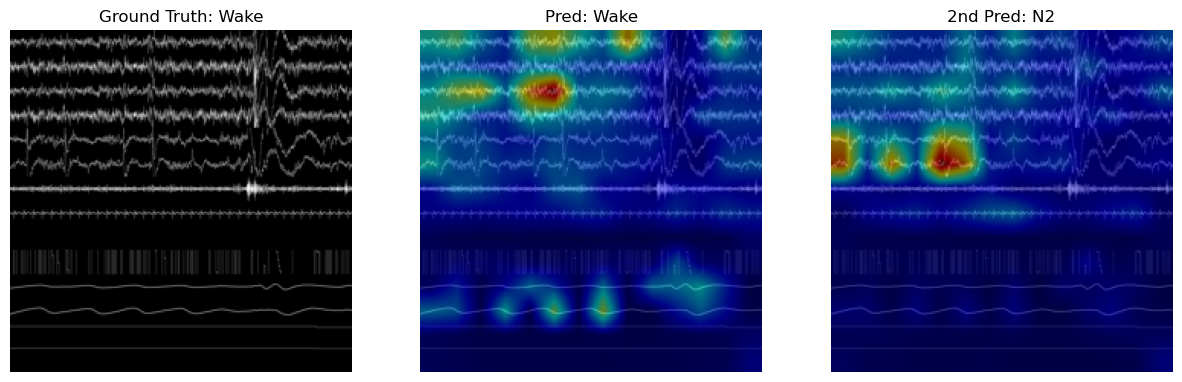

In [41]:
image = ex_img

fig, axs = plt.subplots(1, 3, figsize=(15, 25))
axs[0].imshow(image.permute(1,2,0))
axs[0].set_title(f"Ground Truth: {labels_map[ex_lbl]}")
axs[0].axis("off")

output = model(image.unsqueeze(0).cuda())
print_top_classes(output)
pred, second = get_predictions(output)
im = generate_visualization(image)
axs[1].imshow(im)

# show prediction and explanations
axs[1].set_title(f"Pred: {labels_map[pred]}")
axs[1].axis("off")

# show second prediction
im2 = generate_visualization(image, second)
axs[2].imshow(im2)
axs[2].set_title(f"2nd Pred: {labels_map[second]}")
axs[2].axis("off")
plt.show()

In [33]:
torch.manual_seed(42)

### Visalize multiple images using Dataloader

In [44]:
def visualize_image_heatmap(images, labels):
    for image, label in zip(images, labels):
        # show original image and ground truth label
        fig, axs = plt.subplots(1, 3, figsize=(15, 25))
        axs[0].imshow(image.permute(1, 2, 0))
        label = label.tolist()
        axs[0].set_title(f"Ground Truth: {labels_map[label]}")
        axs[0].axis("off")

        # create output and predictions
        output = model(image.unsqueeze(0).cuda())
        print_top_classes(output)
        # print_top_classes(output)
        pred, second = get_predictions(output)
        im = generate_visualization(image)
        axs[1].imshow(im)

        # show prediction and explanations
        axs[1].set_title(f"Pred: {labels_map[pred]}")
        axs[1].axis("off")
        
        # show second prediction
        im2 = generate_visualization(image, second)
        axs[2].imshow(im2)
        axs[2].set_title(f"2nd Pred: {labels_map[second]}")
        axs[2].axis("off")
        plt.show()

In [46]:
# visualize_image_heatmap(images, labels)